# Recurrent Neural Networks

In this lab we will experiment with recurrent neural networks. We will build a text generation model that predicts a word given the previous words, and hence will allow us to generate a sentence. This can easily be extended to generating a sentence description for a given input image. RNNs are a useful type of model for predicting sequences or handling sequences of things as inputs. In this lab we will use again Pytorch's nn library.

We will also be using the COCO dataset which includes images + textual descriptions (captions) + other annotations. We can browse the dataset here: http://cocodataset.org/#home

First, let's import libraries and make sure we have everything properly installed.

In [73]:
import torch, json, string
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import nltk as nltk
from nltk.tokenize import word_tokenize
from torchvision.models import resnet18 as resnet18
from PIL import Image
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from tqdm import tqdm as tqdm

## 1. Loading and Preprocessing the Text
Pytorch comes with a Dataset class for the COCO dataset but I will write my own class here. This class does two important things: 1) Building a vocabulary with the most frequent words, 2) Building utilities to convert a sentence into a list of word ids, and back. We are not going to be using the images for the purposes of the lab but you will use them in the assignment questions.

In [2]:
from tqdm import tqdm_notebook as tqdm

class CocoCaptions(data.Dataset):
    # Load annotations in the initialization of the object.
    def __init__(self, captionsFile, vocabulary = None):
        self.data = json.load(open(captionsFile))
        self.imageIds = self.data['images']
        self.annotations = self.data['annotations']
        
        # Build a vocabulary if not provided.
        if not vocabulary:
            self.build_vocabulary()
        else:
            self.vocabulary = vocabulary
        
    # Build a vocabulary using the top 5000 words.
    def build_vocabulary(self, vocabularySize = 5000):
        # Count words, this will take a while.
        word_counter = dict()
        for annotation in tqdm(self.annotations, desc = 'Building vocabulary'):
            words = word_tokenize(annotation['caption'].lower())
            for word in words:
                word_counter[word] = word_counter.get(word, 0) + 1
                
        # Sort the words and find keep only the most frequent words.
        sorted_words = sorted(list(word_counter.items()), 
                              key = lambda x: -x[1])
        most_frequent_words = [w for (w, c) in sorted_words[:vocabularySize]]
        word2id = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
        
        # Add a special characters for START, END sentence, and UNKnown words.
        word2id['[END]'] = 0
        word2id['[START]'] = len(word2id)
        word2id['UNK'] = len(word2id)
        id2word = {index: w for (w, index) in word2id.items()}
        self.vocabulary = {'word2id': word2id, 'id2word': id2word}
    
    # Transform a caption into a list of word ids.
    def caption2ids(self, caption):
        word2id = self.vocabulary['word2id']
        caption_ids = [word2id.get(w, word2id['UNK']) for w in word_tokenize(caption.lower())]
        caption_ids.insert(0, word2id['[START]'])
        caption_ids.append(word2id['[END]'])
        return torch.LongTensor(caption_ids)
    
    # Transform a list of word ids into a caption.
    def ids2caption(self, caption_ids):
        id2word = self.vocabulary['id2word']
        return string.join([id2word[w] for w in caption_ids], " ")
    
    # Return imgId, and a random caption for that image.
    def __getitem__(self, index):
        annotation = self.annotations[index]
        return annotation['image_id'], self.caption2ids(annotation['caption'])
    
    # Return the number of elements of the dataset.
    def __len__(self):
        return len(self.annotations)
    
# Let's test the data class.
trainData = CocoCaptions('annotations/captions_train2014.json')
print('Number of training examples: ', len(trainData))

# It would be a mistake to build a vocabulary using the validation set so we reuse.
valData = CocoCaptions('annotations/captions_val2014.json', vocabulary = trainData.vocabulary)
print('Number of validation examples: ', len(valData))

# Print a sample from the training data.
imgId, caption = trainData[0]
print('imgId', imgId)
print('caption', caption.tolist())
print('captionString', trainData.ids2caption(caption))

HBox(children=(IntProgress(value=0, description=u'Building vocabulary', max=414113), HTML(value=u'')))


('Number of training examples: ', 414113)
('Number of validation examples: ', 202654)
('imgId', 318556)
('caption', [5001, 1, 141, 512, 8, 668, 415, 277, 57, 0])
('captionString', u'[START] a very clean and well decorated empty bathroom [END]')


## 2. Making a Data Loader that can Handle Sequences.

Handling sequences is special when processing batches of inputs because each sequence can have a different length. This makes batching complicated, and different libraries have different ways of handling this which might be easier or harder to deal with. Here we are padding the sequences to the maximum sequence length in a given batch. Additionally pytorch has nice utility functions that require sorting the sequences in a batch from longest to shortest.

In [3]:
# The batch builder will pack all sequences of different length into a single tensor by 
# padding shorter sequences with a padding token.
def customBatchBuilder(samples):
    imgIds, captionSeqs = zip(*samples)
    
    # Sort sequences based on length.
    seqLengths = [len(seq) for seq in captionSeqs]
    maxSeqLength = max(seqLengths)
    sorted_list = sorted(zip(list(imgIds), captionSeqs, seqLengths), key = lambda x: -x[2])
    imgIds, captionSeqs, seqLengths = zip(*sorted_list)
    
    # Create tensor with padded sequences.
    paddedSeqs = torch.LongTensor(len(imgIds), maxSeqLength)
    paddedSeqs.fill_(0)
    for (i, seq) in enumerate(captionSeqs):
        paddedSeqs[i, :len(seq)] = seq
    return imgIds, paddedSeqs.t(), seqLengths

# Data loaders in pytorch can use a custom batch builder, which we are using here.
trainLoader = data.DataLoader(trainData, batch_size = 128, 
                              shuffle = True, num_workers = 0,
                              collate_fn = customBatchBuilder, drop_last=True)
valLoader = data.DataLoader(valData, batch_size = 128, 
                            shuffle = False, num_workers = 0,
                            collate_fn = customBatchBuilder, drop_last=True)

# Now let's try using the data loader.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
print('imgIds', imgIds)
print('paddedSequences', paddedSeqs.size())
print('seqLengths', seqLengths)

('imgIds', (497616, 282899, 153671, 83454, 284964, 383884, 313727, 248320, 301409, 140776, 22044, 74099, 420308, 572206, 135344, 318190, 166903, 205126, 9039, 379736, 140180, 77649, 21364, 468771, 476344, 392871, 158334, 162767, 379593, 354519, 209097, 409884, 538270, 440819, 29014, 243734, 224304, 239483, 117019, 529350, 255683, 462429, 409834, 339324, 46981, 558348, 300966, 32074, 18395, 482446, 327970, 547052, 515019, 220529, 104309, 553299, 350670, 276626, 331214, 165907, 235959, 26319, 517005, 439689, 50945, 43560, 416372, 154502, 421744, 319293, 193333, 523985, 317431, 235132, 481760, 335107, 120077, 50552, 152015, 361038, 422050, 498449, 228018, 393097, 266168, 495567, 154209, 477162, 128286, 411969, 325095, 58343, 506901, 138982, 562510, 103361, 168903, 522285, 321546, 496819, 11244, 148361, 46149, 501377, 544884, 55578, 259346, 136757, 543494, 352313, 210570, 314530, 573456, 511345, 472776, 314646, 411700, 489203, 470975, 16362, 199963, 517087, 477861, 127699, 180280, 311938, 



## 3. Building our model using a Recurrent Neural Network.
We will build a model that predicts the next word based on the previous word using a recurrent neural network. Additionally we will be using an Embedding layer which will assign a unique vector to each word. The network will be trained with a softmax + negative log likelihood loss. Similar to classification we will be trying to optimize for the correct word at each time-step.

In [4]:
# By now, we should know that pytorch has a functional implementation (as opposed to class version)
# of many common layers, which is especially useful for layers that do not have any parameters.
# e.g. relu, sigmoid, softmax, etc.
import torch.nn.functional as F

class TextGeneratorModel(nn.Module):
    # The model has three layers: 
    #    1. An Embedding layer that turns a sequence of word ids into 
    #       a sequence of vectors of fixed size: embeddingSize.
    #    2. An RNN layer that turns the sequence of embedding vectors into 
    #       a sequence of hiddenStates.
    #    3. A classification layer that turns a sequence of hidden states into a 
    #       sequence of softmax outputs.
    def __init__(self, vocabularySize):
        super(TextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialHiddenState):
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        
        # Pass the sequence of word embeddings to the RNN.
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        flatSeqOutput = rnnOutput.view(-1, 512)
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
predictions, _ = model(torch.autograd.Variable(paddedSeqs), initialHiddenState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

Here are input and output size tensor sizes:
('inputs', torch.Size([34, 128]))
('outputs', torch.Size([34, 128, 5003]))


## 3. Sampling a New Sentence from the Model.

The code below uses the RNN network as an RNN cell where we only pass one single input word, and a hidden state vector. Then we keep passing the previously predicted word, and previously predicted hidden state to predict the next word. Since the given model is not trained, it will just output a random sequence of words for now. Ideally, the trained model should also learn when to [END] a sentence.

In [17]:
def sample_sentence(model, use_cuda = False):
    counter = 0
    limit = 200
    words = list()

    # Setup initial input state, and input word (we use "the").
    previousWord = torch.LongTensor(1, 1).fill_(trainData.vocabulary['word2id']['the'])
    previousHiddenState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    if use_cuda: 
        previousHiddenState = previousHiddenState.cuda()

    while True:
        # Predict the next word based on the previous hidden state and previous word.
        inputWord = torch.autograd.Variable(previousWord)
        if use_cuda: inputWord = inputWord.cuda()
        predictions, hiddenState = model(inputWord, previousHiddenState)
        nextWordId = np.random.multinomial(1, F.softmax(predictions.squeeze()).data.cpu().numpy(), 1).argmax()
        words.append(trainData.vocabulary['id2word'][nextWordId])
        # Setup the inputs for the next round.
        previousWord.fill_(nextWordId)
        previousHiddenState = hiddenState

        # Keep adding words until the [END] token is generated.
        if nextWordId == trainData.vocabulary['word2id']['[END]'] or counter > limit:
            break
        counter += 1
    
    words.insert(0, 'the')
    words.insert(0, '[START]')
    return string.join(words, " ")

print(sample_sentence(model, use_cuda = False))

[START] the cages intricate paints contains ford keeps late distant pinned smiles pumpkins hawaiian carrier boulevard shines unoccupied magnets makes gloves tone curtained flavors changing pizzas arrows swan support showroom member knee chews stocked cell lipstick cable cupboard dash barriers goggles currently drops odd minutes exiting outdoors owl plans waits power lab hugs hummingbird drive blooming consisting rocks magnifying hangs series hovering robot bar scoop sprawled quiche controlled curiously wheat medieval steak rared airstrip bbq sweeping launching share student historic coaches indoors faces rural crafts fried establishment remodeling double biplane banquet driven upscale tethered carriages past tricycle divider surrounded pulling couch probably tracks heater notebooks chasing bales buses ferry tops stopping spray uniformed bend hear surf fixes atv fly video designs carts homemade t-shirt veggies converse s lounge oncoming decorate throws officer making decker boulder japa

In [24]:
def sample_lstm_sentence(model, use_cuda = False):
    counter = 0
    limit = 200
    words = list()

    # Setup initial input state, and input word (we use "the").
    previousWord = torch.LongTensor(1, 1).fill_(trainData.vocabulary['word2id']['the'])
    previousHiddenState = torch.autograd.Variable(torch.Tensor(1, 1, 512).zero_())
    previousCellState = previousHiddenState
    if use_cuda: 
        previousHiddenState = previousHiddenState.cuda()
        previousCellState = previousCellState.cuda()

    while True:
        # Predict the next word based on the previous hidden state and previous word.
        inputWord = torch.autograd.Variable(previousWord)
        if use_cuda: inputWord = inputWord.cuda()
        predictions, (hiddenState,cellState) = model(inputWord, (previousHiddenState,previousCellState))
        nextWordId = np.random.multinomial(1, F.softmax(predictions.squeeze()).data.cpu().numpy(), 1).argmax()
        words.append(trainData.vocabulary['id2word'][nextWordId])
        # Setup the inputs for the next round.
        previousWord.fill_(nextWordId)
        previousHiddenState = hiddenState
        previousCellState = cellState
        # Keep adding words until the [END] token is generated.
        if nextWordId == trainData.vocabulary['word2id']['[END]'] or counter > limit:
            break
        counter += 1
    
    words.insert(0, 'the')
    words.insert(0, '[START]')
    return string.join(words, " ")

print(sample_sentence(model, use_cuda = False))

[START] the discussing wool macaroni snowboard mercedes office hiking featuring warm rolled blouse next pad wheeler walled sofa portable mantle carpeted transit elevator under pavilion sculpture they paintings fixtures raising vests extending quilt gum friend connecting chatting buying lie grizzly pug electronics umpire live architecture spewing gliding extremely hearty featured snuggling customers squat spewing para heavily bit dishes individual tiered texting landed 1 kiteboard motorcycle boulders backs shirt mickey canvas arched cafe southwest brushes hurdle bun heads yet huge political heads herds attempt mouths washed ride puppy summer skateboarders construction buried runs little party suv windows floating cracked electrical remotes late bends use stripe mass misses difficult upon feature parking dollar or rounding outside autumn coral asparagus nighttime woods pantry focused seeds sport mitt wooden stationed cones flush filtered roller . seaweed kept bra bare propellor drums bur

## 3. Training the Model

Now that data is pre-processed, we can try training the model. An important part is to define our target labels or ground-truth labels. In this text generation model, we want to predict the next word based on the previous word. So we need to provide as the target a shifted version of the input sequence. The code below looks a lot like the code used for training previous models with only small modifications.

In [6]:
from tqdm import tqdm as tqdm

def train_rnn_model(model, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        model = model.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0

        scheduler.step()

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        model.train()  # This is important to call before training!
        _, (_, paddedSeqs, _) = next(enumerate(t))
        hiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
        for (i, (_, paddedSeqs, _)) in enumerate(t):          
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(paddedSeqs)
            target_idx = torch.cat((paddedSeqs[slice(1,inputs.size(1))],torch.LongTensor(1,inputs.size(1)).fill_(0)),0)
            targets = Variable((target_idx.view(1,-1)).squeeze(0))
            
            if use_gpu:
                hiddenState = hiddenState.cuda()
                inputs = inputs.cuda()
                targets = targets.cuda()

            # Forward pass:
            hiddenState = Variable(hiddenState.data)
            predictions, hiddenState = model(inputs, hiddenState)
            outputs = predictions.view(-1,5003) # 5003 = num words 
            loss = criterion(outputs, targets)

            # Backward pass:
            optimizer.zero_grad()
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()
            
            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == targets.data).sum()
            counter += inputs.size(0) * inputs.size(1)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        model.eval()
        _, (_, paddedSeqs, _) = next(enumerate(t))
        vhiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
        for (i, (_, paddedSeqs, _)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(paddedSeqs)
            target_idx = torch.cat((paddedSeqs[slice(1,inputs.size(1))],torch.LongTensor(1,inputs.size(1)).fill_(0)),0)
            targets = Variable((target_idx.view(1,-1)).squeeze(0))
            
            if use_gpu:
                vhiddenState = vhiddenState.cuda()
                inputs = inputs.cuda()
                targets = targets.cuda()

            # Forward pass:
            vhiddenState = Variable(vhiddenState.data)
            predictions, vhiddenState = model(inputs, vhiddenState)
            outputs = predictions.view(-1,5003) 
            loss = criterion(outputs, targets)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == targets.data).sum()
            counter += inputs.size(0) * inputs.size(1)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)


In [7]:
def train_lstm_model(model, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = False):
    if use_gpu:
        model = model.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0

        scheduler.step()

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        model.train()  # This is important to call before training!
        _, (_, paddedSeqs, _) = next(enumerate(t))
        hiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
        cellState = hiddenState
        for (i, (_, paddedSeqs, _)) in enumerate(t):          
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(paddedSeqs)
            target_idx = torch.cat((paddedSeqs[slice(1,inputs.size(1))],torch.LongTensor(1,inputs.size(1)).fill_(0)),0)
            targets = Variable((target_idx.view(1,-1)).squeeze(0))
            
            if use_gpu:
                hiddenState = hiddenState.cuda()
                cellState = cellState.cuda()
                inputs = inputs.cuda()
                targets = targets.cuda()

            # Forward pass:
            hiddenState = Variable(hiddenState.data)
            cellState = Variable(cellState.data)
            predictions, (hiddenState, cellState) = model(inputs, (hiddenState,cellState))
            outputs = predictions.view(-1,5003) # 5003 = num words 
            loss = criterion(outputs, targets)

            # Backward pass:
            optimizer.zero_grad()
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()
            
            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == targets.data).sum()
            counter += inputs.size(0) * inputs.size(1)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)

        # Make a pass over the validation data.
        correct = 0.0
        cum_loss = 0.0
        counter = 0.0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        model.eval()
        _, (_, paddedSeqs, _) = next(enumerate(t))
        hiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
        cellState = hiddenState
        for (i, (_, paddedSeqs, _)) in enumerate(t):
            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(paddedSeqs)
            target_idx = torch.cat((paddedSeqs[slice(1,inputs.size(1))],torch.LongTensor(1,inputs.size(1)).fill_(0)),0)
            targets = Variable((target_idx.view(1,-1)).squeeze(0))
            
            if use_gpu:
                hiddenState = hiddenState.cuda()
                cellState = cellState.cuda()
                inputs = inputs.cuda()
                targets = targets.cuda()

            # Forward pass:
            hiddenState = Variable(hiddenState.data)
            cellState = Variable(cellState.data)
            predictions, (hiddenState, cellState) = model(inputs, (hiddenState,cellState))
            outputs = predictions.view(-1,5003) # 5003 = num words 
            loss = criterion(outputs, targets)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == targets.data).sum()
            counter += inputs.size(0) * inputs.size(1)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)



Now to the actual training call, notice how unlike previous experiments we are using here RMSprop which is a different type of optimizer that is often preferred for recurrent neural networks, although others such as SGD, and ADAM will also work. Additionally we are using nn.NLLLoss for the loss function, which is equivalent to the nn.CrossEntropyLoss function used before. The only difference is that nn.CrossEntropyLoss does the log_softmax operation for us, however in our implementation, we already applied log_softmax to the outputs of the model.

In [36]:
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.001)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[4,7,9],gamma=0.1);

# Train the previously defined model.
train_rnn_model(model, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

Validation epoch 9: 100%|██████████| 1583/1583 [01:39<00:00, 15.86it/s, accuracy=73.4, loss=1.37]


## Lab Questions (10pts)
<span><b>1.</b></span> (2pts) What is the number of parameters of the TextGeneratorModel? 

Vocabulary size = 5003 <br>
Hidden Layer size = 512 <br>
Input size = 300 <br>
Output size = 512<br>

** Parameters ** <br>
_Note:  adding bias for input/hidden and hidden/hidden_<br>
embeddings = 5003 x 300 = 1,500,900<br>
input w.r.t. hidden = 300 x 512 + 512 = 154,112<br>
hidden w.r.t. hidden = 512 x 512 + 512 = 262,656<br>
linear layer = 512 x 5003 + 5003 = 2,566,539<br>

Total parameters:  ** 4,484,207 **

<span><b>2.</b></span> (4pts) Provide an implementation for the function train_rnn_model from section 3, this will be similar to the train_model function used in the previous lab. Then train the model and report a few sentences generated by your model. Use the following figure as reference to make sure you are using the right inputs and targets to train the model. The loss function between predictions and targets should be nn.CrossEntropyLoss(), so you might need to collapse the batch and sequence-length dimensions before passing them to the loss function.

<img src="rnn.png" width="80%"> 

#### (See above for implementation and training output)

In [90]:
model.eval()

# example sentences
cuda = True
print(sample_sentence(model, use_cuda = cuda))
print(sample_sentence(model, use_cuda = cuda))
print(sample_sentence(model, use_cuda = cuda))
print(sample_sentence(model, use_cuda = cuda))
print(sample_sentence(model, use_cuda = cuda))

[START] the usa pitcher took something to bat at the ball . [END]
[START] the thumb looking sad is clean and UNK . [END]
[START] the television with a window sill in the background . [END]
[START] the opponent running during the game has the ball . [END]
[START] the best thick beverage smile are parked along with benches . [END]


<span><b>3. </b></span> (4pts) Create an ImageCaptioningModel class here that predicts a sentence given an input image. This should be an implementation of the model in this paper https://arxiv.org/pdf/1411.4555.pdf (See figure 3 in the paper). This model is very similar to the one implemented in this lab except that the first RNN cell gets the output of a CNN as its input. I'm also illustrating it below using a figure similar to the one in the previous question. For the CNN use Resnet-18. Note: You do not need to train this model, only define it. Feel free to start from the code for the TextGeneratorModel. <img src="im2text.png" width="80%">

#### Image Captioning Class

In [10]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocabularySize):
        super(ImageCaptioningModel, self).__init__()
        self.embedder = nn.Embedding(vocabularySize, 300)
        self.rnn = nn.RNN(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize
        # CNN configuration
        self.cnn = resnet18(pretrained=True)
        for p in self.cnn.parameters():  # freeze weights; only feature extractor
            p.requires_grad = False
        self.cnn.fc = nn.Linear(512, 300) # need output size to match embedding_dim (is trainable)
        self.cnn.eval() # no dropout

    def forward(self, imgs, captions, initialHiddenState):
        batchSequenceLength = captions.size(0)  # 0-dim is sequence-length-dim.
        batchSize = captions.size(1)  # 1-dim is batch dimension.
        
        # the CNN features are now the first input to caption prediction, so we 
        # need to increase the sequence length (caption length) by one element
        outBatchSequenceLength = batchSequenceLength + 1
        
        # Transform word ids into an embedding vector (captions)
        embeddingVectors = self.embedder(captions)
                
        # Get image information and prepend to RNN input.
        # Basically, we use the CNN to extract image features and then
        # we provide the features as the "first" inputs to the RNN.
        cnnOutput = self.cnn(imgs).unsqueeze(0) # produces output of size 1x128x300
        embeddingVectors = torch.cat((cnnOutput,embeddingVectors),0) # prepend image features
                
        # Pass the embeddings to the RNN.
        rnnOutput, finalHiddenState = self.rnn(embeddingVectors, initialHiddenState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        flatSeqOutput = rnnOutput.view(-1, 512)
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(outBatchSequenceLength, batchSize, self.vocabularySize), \
               finalHiddenState

        
# FOR TESTING        
# batch of 128 fake images (to accompany a batch of 128 captions)
# in a real implementation, this would be loaded from a dataloader
images = torch.FloatTensor(128,3,224,224)

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = ImageCaptioningModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, captions, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = Variable(torch.Tensor(1, captions.size(1), 512).zero_())
predictions, _ = model(Variable(images), Variable(captions), initialHiddenState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', captions.size())
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) 

Here are input and output size tensor sizes:
('inputs', torch.Size([20, 128]))
('outputs', torch.Size([21, 128, 5003]))


### Optional Questions (8pts)

<span><b>1. </b></span> (1pts) What is the number of parameters of the ImageCaptioningModel from Q3?

Vocabulary size = 5003 <br>
Hidden Layer size = 512 <br>
Input size = 300 <br>
Output size = 512<br>

** Parameters ** <br>
_Note:  adding bias for input/hidden and hidden/hidden_<br>
CNN FC Layer = 512 x 300 + 300 = 153,900<br>
embeddings = 5003 x 300 + 300 = 1,501,200<br>
input w.r.t. hidden = 300 x 512 + 512 = 154,112<br>
hidden w.r.t. hidden = 512 x 512 + 512 = 262,656<br>
linear layer = 512 x 5003 + 5003 = 2,566,539<br>

Total parameters:  ** 4,638,407 **

<span><b>2. </b></span> (3pts) Modify the TextGeneratorModel to use an LSTM instead, and retrain the model. Report results using this model.

#### LSTM Model Definition

In [11]:
class LSTMTextGeneratorModel(nn.Module):
    def __init__(self, vocabularySize):
        super(LSTMTextGeneratorModel, self).__init__()
        # See documentation for nn.Embedding here:
        # http://pytorch.org/docs/master/nn.html#torch.nn.Embedding
        self.embedder = nn.Embedding(vocabularySize, 300)
        self.lstm = nn.LSTM(300, 512, batch_first = False)
        self.classifier = nn.Linear(512, vocabularySize)
        self.vocabularySize = vocabularySize

    # The forward pass makes the sequences go through the three layers defined above.
    def forward(self, paddedSeqs, initialState):
        batchSequenceLength = paddedSeqs.size(0)  # 0-dim is sequence-length-dim.
        batchSize = paddedSeqs.size(1)  # 1-dim is batch dimension.
        
        # Transform word ids into an embedding vector.
        embeddingVectors = self.embedder(paddedSeqs)
        
        # Pass the sequence of word embeddings to the RNN.
        rnnOutput, finalState = self.lstm(embeddingVectors, initialState)
        
        # Collapse the batch and sequence-length dimensions in order to use nn.Linear.
        flatSeqOutput = rnnOutput.view(-1, 512)
        predictions = self.classifier(flatSeqOutput)
        
        # Expand back the batch and sequence-length dimensions and return. 
        return predictions.view(batchSequenceLength, batchSize, self.vocabularySize), \
               finalState

# Let's test the model on some input batch.
vocabularySize = len(trainData.vocabulary['word2id'])
model = TextGeneratorModel(vocabularySize)

# Create the initial hidden state for the RNN.
index, (imgIds, paddedSeqs, seqLengths) = next(enumerate(trainLoader))
initialHiddenState = Variable(torch.Tensor(1, paddedSeqs.size(1), 512).zero_())
initialCellState = initialHiddenState
initialState = (initialHiddenState, initialCellState)
predictions, _ = model(torch.autograd.Variable(paddedSeqs), initialState)

print('Here are input and output size tensor sizes:')
# Inputs are seqLength x batchSize x 1 
print('inputs', paddedSeqs.size()) # 10 input sequences.
# Outputs are seqLength x batchSize x vocabularySize
print('outputs', predictions.size()) # 10 output softmax predictions over our vocabularySize outputs.

Here are input and output size tensor sizes:
('inputs', torch.Size([25, 128]))
('outputs', torch.Size([25, 128, 5003]))


#### Train the LSTM Model

In [12]:
vocabularySize = len(trainData.vocabulary['word2id'])
lstm_model = LSTMTextGeneratorModel(vocabularySize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(lstm_model.parameters(), lr=0.01)
scheduler = lr_scheduler.MultiStepLR(optimizer,milestones=[4,7,9],gamma=0.1);

# Train the previously defined model.
train_lstm_model(lstm_model, criterion, optimizer, scheduler, trainLoader, valLoader, n_epochs = 10, use_gpu = True)

Validation epoch 9: 100%|██████████| 1583/1583 [01:50<00:00, 14.31it/s, accuracy=74.3, loss=1.3] 


#### Example Sentences

In [32]:
lstm_model.eval()
cuda = True
print(sample_lstm_sentence(lstm_model, use_cuda = cuda))
print(sample_lstm_sentence(lstm_model, use_cuda = cuda))
print(sample_lstm_sentence(lstm_model, use_cuda = cuda))
print(sample_lstm_sentence(lstm_model, use_cuda = cuda))
print(sample_lstm_sentence(lstm_model, use_cuda = cuda))

[START] the cat hides inside of the box [END]
[START] the road sign blurred from behind . [END]
[START] the mountain range . [END]
[START] the kitchen counter has many dishes on the stove . [END]
[START] the pastries stuck in a kitchen . [END]


<span><b>3. </b></span> (4pts) In this question, you will have to reconstruct an input image from its activations. I will not provide you with the image, only the activation values obtained for a certain layer. You will have access to the code that was used to compute these activations. You will have to use back-propagation to reconstruct the input image. Show the reconstructed input image and tell us who is in the picture. Note: Look at the content reconstruction from outputs performed in https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Gatys_Image_Style_Transfer_CVPR_2016_paper.html

In [ ]:
import torchvision.models as models
model = models.vgg16(pretrained = True)

In [ ]:
import pickle
import torchvision.transforms as transforms
from PIL import Image

preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

def model_F(input, kOutput = 19):
    prev_input = input
    for layer_id in range(0, kOutput + 1):
        current_input = model.features[layer_id](prev_input)
        prev_input = current_input
    return current_input

# Read the incognito image. (Obviously this is not provided in the Lab assignment.)
image = preprocessFn(Image.open('incognito.jpg').convert('RGB'))
image = Variable(image.unsqueeze(0))

# Obtain the output of the VGG layer 19.
model.eval()
target = Variable(model_F(image).data) # Repack variable.

print('image.size()', image.size())
print('layer-19-output.size()', target.size())
torch.save(target.data, open('layer-19-output.p', 'w'))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

299/|/100%|| 299/300 [04:26<00:00,  1.12it/s, loss=0.769]

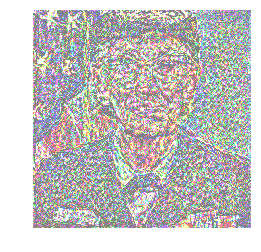

In [237]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

def imshow(img):
    # convert torch tensor to PIL image and then show image inline.
    img = transforms.ToPILImage()(img[0].cpu() * 0.5 + 0.5) # denormalize tensor before convert
    plt.imshow(img, aspect = None)
    plt.axis('off')
    plt.gcf().set_size_inches(4, 4)
    plt.show()

target = Variable(torch.load(open('layer-19-output.p')))

# Your solution goes here. Show the reconstructed input and tell us who is depicted in the incognito.jpg image.

#w1 = Variable(torch.randn(1,3,224,224), requires_grad=True) # only used to start first training round
w1 = saved
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax([w1],lr=0.2)

#learning_rate = 5
tq = tqdm(range(300))
for t in tq:
    # forward pass
    arg = w1.view(1,3,224,224)
    prev_input = arg
    for layer_id in range(0, 20):
        current_input = model.features[layer_id](prev_input)
        prev_input = current_input
    feats = current_input # intermediate representation
    prediction = arg      # predicted 224x224 image

    # loss
    loss = criterion(feats, target) # optimize loss w.r.t. input image (feats)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # ugly implementation:  update gradients
    #w1.data -= learning_rate * w1.grad.data
    #w1.grad.data.zero_()
    
    loss_val = loss.data[0]
    tq.set_postfix(loss = loss.data[0])

imshow(prediction.data.clamp(0,1))

The person in the image is Rear Admiral Grace Hopper, US Navy, a famous computer scientist who helped develop one of the first compilers.  (I ran the training routine above multiple times and manually adjusted learning rates every 300 iterations--not super smooth, but it worked.)

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>